## Data preparation and exploration
### Creating Spark Session
1. Create a SparkConf object for using as many local cores as possible, for a proper application name, and for changing the max partition byte configuration to enable a minimum of 2 partitions when reading each file in Spark SQL (so each dataframe should have at least 4 partitions when reading from the given datafiles).
2. Then create a SparkSession using the SparkConf object.

In [1]:
# Import libraries needed from pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

# Create Spark Configuration Object
master = "local[*]"
# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "Spark Assignment 2A"
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name).set("spark.files.maxPartitionBytes",17000000).set("spark.sql.files.maxPartitionBytes",17000000)

# Create SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

### Loading the data
1. Load each activity data into a Spark dataframe and cache the data. Then print out the row count of each dataframe.
    
*In the cell below we can see the load process for the memory process files. However, the file 2 was not complying with the schema, for this reason I used `inferSchema` so that the problematic fields can be loaded as `StringType`.*

In [2]:
from pyspark.sql.types import *

# Specify schema memory
schema_mem = StructType([
    StructField('ts', IntegerType(), True),
    StructField('PID', IntegerType(), True),
    StructField('MINFLT', IntegerType(), True),
    StructField('MAJFLT', IntegerType(), True),
    StructField('VSTEXT', IntegerType(), True),
    StructField('VSIZE', DoubleType(), True),
    StructField('RSIZE', DoubleType(), True),
    StructField('VGROW', DoubleType(), True),
    StructField('RGROW', DoubleType(), True),
    StructField('MEM', DoubleType(), True),
    StructField('CMD', StringType(), True),
    StructField('attack', IntegerType(), True),
    StructField('type', StringType(), True)
])

#Load the CSV File
mem1_df = spark.read.format('csv')\
            .schema(schema_mem).option('header',True).load('linux_memory_1.csv')
mem2_df = spark.read.format('csv')\
            .option('header',True).option('inferSchema',True).load('linux_memory_2.csv')

Now we will follow the same process with the process activity files.

In [3]:
schema_proc = StructType([
    StructField('ts', IntegerType(), True),
    StructField('PID', IntegerType(), True),
    StructField('TRUN', IntegerType(), True),
    StructField('TSLPI', IntegerType(), True),
    StructField('TSLPU', IntegerType(), True),
    StructField('POLI', StringType(), True),
    StructField('NICE', IntegerType(), True),
    StructField('PRI', IntegerType(), True),
    StructField('RTPR', IntegerType(), True),
    StructField('CPUNR', IntegerType(), True),
    StructField('Status', StringType(), True),
    StructField('EXC', IntegerType(), True),
    StructField('State', StringType(), True),
    StructField('CPU', DoubleType(), True),
    StructField('CMD', StringType(), True),
    StructField('attack', IntegerType(), True),
    StructField('type', StringType(), True)
])

proc1_df = spark.read.format('csv')\
            .schema(schema_proc).option('header',True).load('linux_process_1.csv')
proc2_df = spark.read.format('csv')\
            .schema(schema_proc).option('header',True).load('linux_process_2.csv')

df_list = [mem1_df, mem2_df, proc1_df, proc2_df]
for df in df_list:
    df.cache()

In [4]:
# Checking that the dataframe has been cached
mem1_df.storageLevel

StorageLevel(True, True, False, True, 1)

In [5]:
# Checking the partitions of each dataframe
for df in df_list:
    print(df.rdd.getNumPartitions())

4
4
4
4


In [6]:
for df in df_list:
    print("Row count:",df.count(),"Column count:", len(df.columns))

Row count: 1000000 Column count: 13
Row count: 1000000 Column count: 13
Row count: 1000000 Column count: 17
Row count: 927968 Column count: 17


In [7]:
# Inspecting the dataframes
mem1_df.show(3)
proc1_df.show(3)

+----------+----+------+------+------+-----+-----+-----+-----+----+-----------+------+------+
|        ts| PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW| MEM|        CMD|attack|  type|
+----------+----+------+------+------+-----+-----+-----+-----+----+-----------+------+------+
|1554218915|3257|859502|    54|   193|  2.0|519.1|  2.0|519.1|0.14|Web-Content|     0|normal|
|1554218920|3197|247354|    95|   193|  2.6|402.0|  2.6|402.0|0.11|    firefox|     0|normal|
|1554218925|1442| 57311|    33|  2219|764.2|290.7|764.2|290.7|0.08|       Xorg|     0|normal|
+----------+----+------+------+------+-----+-----+-----+-----+----+-----------+------+------+
only showing top 3 rows

+----------+----+----+-----+-----+----+----+---+----+-----+------+---+-----+----+-----------+------+------+
|        ts| PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State| CPU|        CMD|attack|  type|
+----------+----+----+-----+-----+----+----+---+----+-----+------+---+-----+----+-----------+------+-

In [8]:
# Check schemas
for df in df_list:
    df.printSchema()

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: integer (nullable = true)
 |-- MAJFLT: integer (nullable = true)
 |-- VSTEXT: integer (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: double (nullable = true)
 |-- VGROW: double (nullable = true)
 |-- RGROW: double (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: integer (nullable = true)
 |-- type: string (nullable = true)

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: string (nullable = true)
 |-- MAJFLT: string (nullable = true)
 |-- VSTEXT: string (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: string (nullable = true)
 |-- VGROW: string (nullable = true)
 |-- RGROW: string (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: integer (nullable = true)
 |-- type: string (nullable = true)

root
 |-- ts: integer (nullab

The schemas printed above show that only for memory2 dataset the datatypes are not according to the metadata, therefore this will be modified in the next section

2. For each column in each dataframe above,
    * Check the null data (if any) and print out the corresponding count in each column

In [9]:
from pyspark.sql.functions import isnan, when, count, col

for df in df_list:
    df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+

+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
| ts|PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|CPU|CMD|attack|type|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+--

We can see above that the dataframes don't contain any null data, and by looking at the schemas printed above we can also observe that the use of each file's schema was correctly implemented. The use of `inferSchema` has loaded the second dataset of memory process with some incorrect fields that are as `StringType`. In the following cells we will explore the reason why to then perform some wrangling to the required columns and convert them into the proper datatype. 

**MINFLT**  
For each of the problematic fields we will first try to cast into the correct datatype and save it as a new column. Then we can observe the null values and the information that was there before in order to understand how to clean the data properly. (As a reference we will print some values from the same column but on the first file which are not presenting problems with the datatype)

In [10]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType
# mem2_df = spark.read.format('csv')\
#             .option('header',True).option('inferSchema',True).load('linux_memory_2.csv')
mem2_df2 = mem2_df.withColumn('MINFLT_INT',F.col('MINFLT').cast(IntegerType()))
mem2_df2.select('MINFLT','MINFLT_INT').filter(col('MINFLT_INT').isNull()).show(5)
mem1_df.select('MINFLT').show(5)

+------+----------+
|MINFLT|MINFLT_INT|
+------+----------+
|  132K|      null|
|  132K|      null|
|  132K|      null|
|  132K|      null|
|  132K|      null|
+------+----------+
only showing top 5 rows

+------+
|MINFLT|
+------+
|859502|
|247354|
| 57311|
| 68006|
| 72300|
+------+
only showing top 5 rows



**MAJFLT**

In [11]:
mem2_df2 = mem2_df.withColumn('MAJFLT_INT',F.col('MAJFLT').cast(IntegerType()))
mem2_df2.select('MAJFLT','MAJFLT_INT').filter(col('MAJFLT_INT').isNull()).show(5)
mem1_df.select('MAJFLT').show(5)

+------+----------+
|MAJFLT|MAJFLT_INT|
+------+----------+
|224.2M|      null|
|224.2M|      null|
|224.2M|      null|
|224.2M|      null|
|224.2M|      null|
+------+----------+
only showing top 5 rows

+------+
|MAJFLT|
+------+
|    54|
|    95|
|    33|
|    17|
|    69|
+------+
only showing top 5 rows



**VSTEXT**

In [12]:
mem2_df2 = mem2_df.withColumn('VSTEXT_INT',F.col('VSTEXT').cast(IntegerType()))
mem2_df2.select('VSTEXT','VSTEXT_INT').filter(col('VSTEXT_INT').isNull()).show(5)
mem1_df.select('VSTEXT').show(5)

+------+----------+
|VSTEXT|VSTEXT_INT|
+------+----------+
| 9392K|      null|
| 9392K|      null|
| 9392K|      null|
| 9392K|      null|
| 9392K|      null|
+------+----------+
only showing top 5 rows

+------+
|VSTEXT|
+------+
|   193|
|   193|
|  2219|
|  3063|
|  1350|
+------+
only showing top 5 rows



**RSIZE**  
This field was presenting nulls after removing the initial 'M' observed in the first 5 rows, therefore we will remove it (using regex) and inspect what other values could be problematic (Below it can be observed that this row contained characters 'M' and 'K')

In [13]:
from pyspark.sql.functions import regexp_replace

mem2_df2 = mem2_df.withColumn('RSIZE_INT',F.col('RSIZE').cast(IntegerType()))
mem2_df2.select('RSIZE','RSIZE_INT').filter(col('RSIZE_INT').isNull()).show(5)
mem1_df.select('RSIZE').show(5)
mem2_df2 = mem2_df.withColumn('RSIZE_INT',regexp_replace(col("RSIZE"), "M", "").cast(DoubleType()))
mem2_df2.select('RSIZE','RSIZE_INT').filter(col('RSIZE_INT').isNull()).show(5)

+------+---------+
| RSIZE|RSIZE_INT|
+------+---------+
|224.2M|     null|
|224.2M|     null|
|224.2M|     null|
|224.2M|     null|
|224.2M|     null|
+------+---------+
only showing top 5 rows

+-----+
|RSIZE|
+-----+
|519.1|
|402.0|
|290.7|
|116.8|
|109.6|
+-----+
only showing top 5 rows

+-----+---------+
|RSIZE|RSIZE_INT|
+-----+---------+
|   0K|     null|
|   0K|     null|
|   0K|     null|
|   0K|     null|
|   0K|     null|
+-----+---------+
only showing top 5 rows



**VGROW**  
From the field above we observed that 'M' and 'K' can be present at the same time, so now in order to observe what else could be problematic we will remove both characters from the beginning and see what is left. (Below we can observe that white spaces were also observed among the values)

In [14]:
mem2_df2 = mem2_df.withColumn('VGROW_INT',F.col('VGROW').cast(IntegerType()))
mem2_df2.select('VGROW','VGROW_INT').filter(col('VGROW_INT').isNull()).show(5)
mem1_df.select('VGROW').show(5)
mem2_df2 = mem2_df.withColumn('VGROW_INT',regexp_replace(col("VGROW"), "[M,K]", "").cast(DoubleType()))
mem2_df2.select('VGROW','VGROW_INT').filter(col('VGROW_INT').isNull()).show(5)

+-----+---------+
|VGROW|VGROW_INT|
+-----+---------+
|9392K|     null|
|9392K|     null|
|9392K|     null|
|9392K|     null|
|9392K|     null|
+-----+---------+
only showing top 5 rows

+-----+
|VGROW|
+-----+
|  2.0|
|  2.6|
|764.2|
|725.9|
|  1.4|
+-----+
only showing top 5 rows

+-------+---------+
|  VGROW|VGROW_INT|
+-------+---------+
| 09.8 1|     null|
|011.2 2|     null|
|07396 1|     null|
|012.0 3|     null|
|01588 1|     null|
+-------+---------+
only showing top 5 rows



**RGROW**

In [15]:
mem2_df2 = mem2_df.withColumn('RGROW_INT',F.col('RGROW').cast(IntegerType()))
mem2_df2.select('RGROW','RGROW_INT').filter(col('RGROW_INT').isNull()).show(5)
mem1_df.select('RGROW').show(5)

+-----+---------+
|RGROW|RGROW_INT|
+-----+---------+
|   0K|     null|
|   0K|     null|
|   0K|     null|
|   0K|     null|
|   0K|     null|
+-----+---------+
only showing top 5 rows

+-----+
|RGROW|
+-----+
|519.1|
|402.0|
|290.7|
|116.8|
|109.6|
+-----+
only showing top 5 rows



After observing the additional characters which were producing nulls when casting into numeric, we can now remove them using regular expressions and verify if the columns have the correct data type to then validate that there are no nulls in the dataset. To do this we can use the following function which takes the dataframe, the column to cast and the data type to cast as arguments and returns the dataframe with the correct column datatype.

In [16]:
def reformat_column(df, colname, targetDatatype):    
    df2 = df.withColumn('TEMP',regexp_replace(col(colname), "\s", "").cast(targetDatatype))
    kdf = df2.filter(col('TEMP').isNull()).filter(col(colname).rlike('K')) #get rows with K in them 
    mdf = df2.filter(col('TEMP').isNull()).filter(col(colname).rlike('M')) #get rows with M in them
    df = df2.filter(col('TEMP').isNotNull())\
                .withColumn(colname,regexp_replace(col(colname), "\s", "").cast(targetDatatype)) #get rows without nulls and cast in correct format 
    
    if kdf.count() > 0:
        kdf = kdf.withColumn(colname, regexp_replace(col(colname), 'K', '').cast(targetDatatype))\
            .withColumn(colname, col(colname)*1000)
        df = df.union(kdf)
    if mdf.count() > 0:
        mdf = mdf.withColumn(colname,regexp_replace(col(colname), 'M', '').cast(targetDatatype))\
            .withColumn(colname, col(colname)*1000000)
        df = df.union(mdf)
        
    return df.drop('TEMP').coalesce(8)

In [17]:
mem2_df = spark.read.format('csv')\
            .option('header',True).option('inferSchema',True).load('linux_memory_2.csv')

mem2_df = reformat_column(mem2_df, 'MINFLT', IntegerType())
mem2_df = reformat_column(mem2_df, 'MAJFLT', IntegerType())
mem2_df = reformat_column(mem2_df, 'VSTEXT', IntegerType())
mem2_df = reformat_column(mem2_df, 'RSIZE', DoubleType())
mem2_df = reformat_column(mem2_df, 'VGROW', DoubleType())
mem2_df = reformat_column(mem2_df, 'RGROW', DoubleType())

In [18]:
mem2_df.printSchema()

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: integer (nullable = true)
 |-- MAJFLT: integer (nullable = true)
 |-- VSTEXT: integer (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: double (nullable = true)
 |-- VGROW: double (nullable = true)
 |-- RGROW: double (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: integer (nullable = true)
 |-- type: string (nullable = true)



In [19]:
mem2_df.cache()
print('Memory activity partitions:',mem2_df.rdd.getNumPartitions())
mem2_df.storageLevel # Validating that is cached

Memory activity partitions: 8


StorageLevel(True, True, False, True, 1)

In [20]:
mem2_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in mem2_df.columns]).show()

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



In [21]:
# mem2_df = mem2_df.coalesce(4)

### Exploring the data 
*After observing the dataframes without null values and with the same schema, we will first put them together as `mem_df` and `proc_df` by combining the two separate files*

In [22]:
mem_df = mem1_df.union(mem2_df)
mem_df.cache()
proc_df = proc1_df.union(proc2_df)
proc_df.cache()
print('Memory activity partitions:',mem_df.rdd.getNumPartitions())
print('Process activity partitions:',proc_df.rdd.getNumPartitions())
mem_df.storageLevel # Validating that is cached

Memory activity partitions: 12
Process activity partitions: 8


StorageLevel(True, True, False, True, 1)

In [23]:
mem_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in mem_df.columns]).show()
proc_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in proc_df.columns]).show()

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+

+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
| ts|PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|CPU|CMD|attack|type|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
|  0|  0|   0|    0|    0|   0|   0|  0|   0|    0|     0|  0|    0|  0|  0|     0|   0|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+



In [24]:
print("Memory Activity:")
mem_df.groupBy('attack').count().show()

Memory Activity:
+------+-------+
|attack|  count|
+------+-------+
|     1| 205623|
|     0|1794377|
+------+-------+



In [25]:
print("Process Activity:")
proc_df.groupBy('attack').count().show()

Process Activity:
+------+-------+
|attack|  count|
+------+-------+
|     1| 291364|
|     0|1636604|
+------+-------+



In [26]:
print("Kind of attack count for Process Activity:")
proc_df.groupBy('type').count().sort(col('count').desc()).show()

Kind of attack count for Process Activity:
+---------+-------+
|     type|  count|
+---------+-------+
|   normal|1636604|
|     ddos|  71603|
|      dos|  70721|
| password|  51409|
|injection|  41311|
| scanning|  38449|
|      xss|  17759|
|     mitm|    112|
+---------+-------+



In the memory activity it is observed that the class attack = 1 (there was an attack) is considerably smaller compared to the cases where there was no attack (around 9 times smaller in the complete memory activity data). In the case of the process activity we observe a similar situation with the class 1 being considerably smaller again. 

As a consequence, in the kind of attack count we can observe that normal (corresponding to no attack) is as expected much bigger than the other classes and then most of them are not as different except for `mitm` which is very small with only 112 cases (Although `xss` is around 4 times smaller than `ddos` or `dos`). 

This results are relevant in order to realize that the use of accuracy might not be a good measurement for our model evaluation in the future and it will be better to consider an alternative approach like the F1 score.

2. For each numeric feature in each activity, show the basic statistics (including count, mean, stddev, min, max); for each non-numeric feature in each activity, display the top-10 values and the corresponding counts.
    * No need to show the labels at “attack” or “type” column

**Numeric features Memory activity**

In [27]:
non_num_mem = {'CMD','attack','type'}
mem_df.select([c for c in mem_df.columns if c not in non_num_mem]).describe().toPandas()

,summary,ts,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM
0,count,2000000,2000000,2000000,2000000,2000000,2000000,2000000,2000000,2000000,2000000
1,mean,1.55624581707609E9,4999.360446,983.344344,986703.878731,46453.2681675,4496.419966451404,23722.888664199574,984.4668735600001,483.17466254999994,0.0033851649999978852
2,stddev,984463.3682874208,4887.313351921406,19229.610980642155,1.4825685595235161E7,658730.2055745388,9046.338093399,1986383.180873493,86174.82585202281,1491.4761059171833,0.010943425779985798
3,min,1554216855,1007,0,0,0,0.0,-9728.0,-9392000.0,0.0,0.0
4,max,1558355716,53096,8050000,224000000,11200000,88040.0,2.244E8,1.116E7,98920.0,0.44


**Numeric features Process activity**

In [28]:
non_num_proc = {'CMD','attack','type','POLI','Status','State'}
proc_df.select([c for c in proc_df.columns if c not in non_num_proc]).describe().toPandas()

,summary,ts,PID,TRUN,TSLPI,TSLPU,NICE,PRI,RTPR,CPUNR,EXC,CPU
0,count,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968
1,mean,1.5563198311840394E9,5068.709770597852,0.0632287465352122,3.508334163222626,3.6100184235422994E-4,4.634469555511295,111.26826741937626,0.0,1.9210142491991569,0.030275398761805176,0.02238527299210013
2,stddev,771350.0248039652,4987.784329320474,0.2478258709041608,6.988459728531766,0.04421874419214576,8.40318986475202,22.624445062102996,0.0,1.52740472259029,1.4619498567691742,0.1362894368718419
3,min,1554216855,1007,0,0,0,0,0,0,0,0,0.0
4,max,1557593017,53080,12,70,21,20,139,0,5,127,4.02


**Non-Numeric features Memory activity**

In [29]:
print("Non-Numeric Memory Activity:\n")
for cat in non_num_mem:
    if cat not in {'attack','type'}:
        print("-------%s-------" %(cat))
        mem_df.groupBy(cat).count().sort(col('count').desc()).show(10)

Non-Numeric Memory Activity:

-------CMD-------
+----------+------+
|       CMD| count|
+----------+------+
|      atop|325985|
|   apache2| 89761|
| jfsCommit| 81714|
|  vmtoolsd| 77871|
|      Xorg| 49981|
|  nautilus| 48356|
|irqbalance| 44387|
|    compiz| 44356|
|  ostinato| 43024|
|     drone| 41392|
+----------+------+
only showing top 10 rows



**Non-Numeric features Process activity**

In [30]:
print("Non-Numeric Process Activity:\n")
for cat in non_num_proc:
    if cat not in {'attack','type'}:
        print("-------%s-------" %(cat))
        proc_df.groupBy(cat).count().sort(col('count').desc()).show(10)

Non-Numeric Process Activity:

-------POLI-------
+----+-------+
|POLI|  count|
+----+-------+
|norm|1861558|
|   0|  53216|
|   -|  13194|
+----+-------+

-------Status-------
+------+-------+
|Status|  count|
+------+-------+
|     -|1416322|
|     0| 438984|
|    NE|  48602|
|     N|  23313|
|    NS|    743|
|     C|      3|
|    NC|      1|
+------+-------+

-------State-------
+-----+-------+
|State|  count|
+-----+-------+
|    S|1676350|
|    I|  98986|
|    R|  84753|
|    E|  66410|
|    Z|   1118|
|    D|    344|
|    T|      7|
+-----+-------+

-------CMD-------
+--------------+------+
|           CMD| count|
+--------------+------+
|          atop|441180|
|       apache2|313143|
|      vmtoolsd|112029|
|          Xorg| 66813|
|      nautilus| 63449|
|gnome-terminal| 47628|
|        compiz| 44386|
|    irqbalance| 44324|
|      ostinato| 42979|
|         drone| 41390|
+--------------+------+
only showing top 10 rows



  **Note:** This section was based on Kienzler, R. Fundamentals of scalable Data Science. Retrieved from https://www.coursera.org/lecture/ds/plotting-with-apachespark-and-pythons-matplotlib-mjCxm

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]

**Plot 1 Memory activity**

In [32]:
mem_pl1_df = mem_df.select('ts','attack').sort(col('ts').asc()) #Sort by ts to have the correct time order
mem_pl1_rdd = mem_pl1_df.rdd.sample(False, 0.05, seed = 123).map(lambda x: (x[0],x[1]))
print('Sampled records:',len(mem_pl1_rdd.collect()))
mem_pl1_ts = mem_pl1_rdd.map(lambda x: x[0]).collect()
mem_pl1_attack = mem_pl1_rdd.map(lambda x: x[1]).collect()

Sampled records: 99772


Text(0.5, 1.0, 'Run chart Attacks over time (sampled records: 100K)')

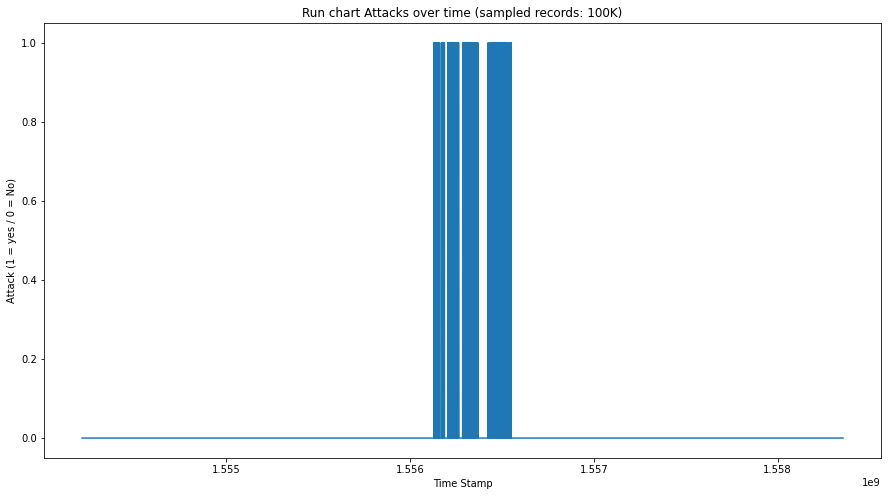

In [33]:
plt.plot(mem_pl1_ts, mem_pl1_attack)
plt.xlabel('Time Stamp')
plt.ylabel('Attack (1 = yes / 0 = No)')
plt.title('Run chart Attacks over time (sampled records: 100K)')

**Discussion:** In the above plot we observe the time stamp for a sample of around 100K records (corresponding to 5% of the memory activity) and whether the record was classified as attack or not. The graph shows that the observed attacks are concentrated close to each other which shows that identifying them early is crucial in order to take measurements to prevent following attacks which seem to follow closely after the first one is performed.

**Plot2 Memory Activity**

In [34]:
mem_pl2_df1 = mem_df.select('attack','VSTEXT','RSIZE','MAJFLT','VSIZE').filter(col('attack')==1)
mem_pl2_df0 = mem_df.select('attack','VSTEXT','RSIZE','MAJFLT','VSIZE').filter(col('attack')==0)

mem_pl2_rdd1 = mem_pl2_df1.rdd.sample(False, 0.1, seed = 123).map(lambda x: (x[0],x[1],x[2],x[3],x[4]))
mem_pl2_rdd0 = mem_pl2_df0.rdd.sample(False, 0.05, seed = 123).map(lambda x: (x[0],x[1],x[2],x[3],x[4]))
print('Sampled records:',len(mem_pl2_rdd1.collect()))
print('Sampled records:',len(mem_pl2_rdd0.collect()))

mem_pl2_vstext1 = mem_pl2_rdd1.map(lambda x: x[1]).collect()
mem_pl2_rsize1 = mem_pl2_rdd1.map(lambda x: x[2]).collect()
mem_pl2_majflt1 = mem_pl2_rdd1.map(lambda x: x[3]).collect()
mem_pl2_vsize1 = mem_pl2_rdd1.map(lambda x: x[4]).collect()

mem_pl2_vstext0 = mem_pl2_rdd0.map(lambda x: x[1]).collect()
mem_pl2_rsize0 = mem_pl2_rdd0.map(lambda x: x[2]).collect()
mem_pl2_majflt0 = mem_pl2_rdd0.map(lambda x: x[3]).collect()
mem_pl2_vsize0 = mem_pl2_rdd0.map(lambda x: x[4]).collect()

Sampled records: 20585
Sampled records: 89597


([<matplotlib.axis.XTick at 0x7f1634ff1430>,
 [Text(0, 0, '1'), Text(2, 0, '0')])

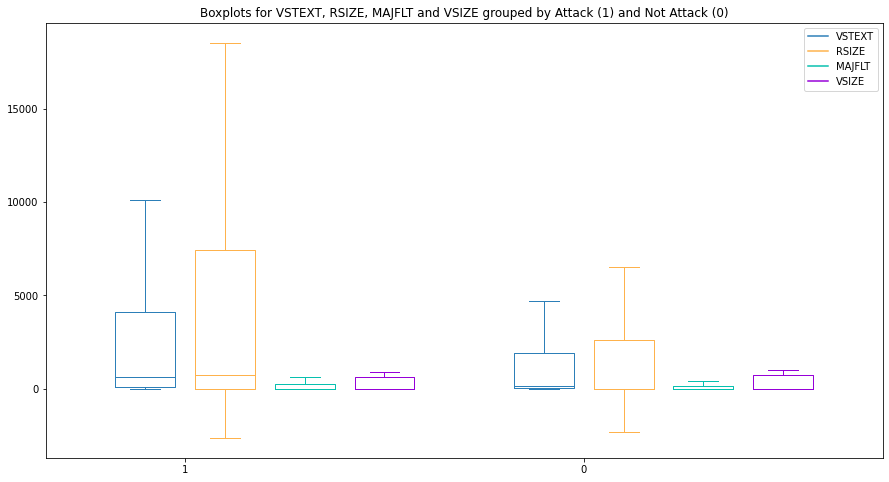

In [35]:
import numpy as np 

## https://stackoverflow.com/questions/16592222/matplotlib-group-boxplots
def box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

ticks = ['1', '0']

data_1 = [mem_pl2_vstext1, mem_pl2_vstext0]
data_2 = [mem_pl2_rsize1, mem_pl2_rsize0]
data_3 = [mem_pl2_majflt1, mem_pl2_majflt0]
data_4 = [mem_pl2_vsize1, mem_pl2_vsize0]

bp1 = plt.boxplot(data_1, positions=np.array(range(len(data_1)))*2.0-0.2, sym='', widths=0.3)
bp2 = plt.boxplot(data_2, positions=np.array(range(len(data_2)))*2.0+0.2, sym='', widths=0.3)
bp3 = plt.boxplot(data_3, positions=np.array(range(len(data_3)))*2.0+0.6, sym='', widths=0.3)
bp4 = plt.boxplot(data_4, positions=np.array(range(len(data_4)))*2.0+1, sym='', widths=0.3)

box_color(bp1, '#2c7fb8') 
box_color(bp2, '#feb24c')
box_color(bp3, '#07c0af') 
box_color(bp4, '#9600d8') #e8751b 

plt.plot([], c='#2c7fb8', label='VSTEXT')
plt.plot([], c='#feb24c', label='RSIZE')
plt.plot([], c='#07c0af', label='MAJFLT')
plt.plot([], c='#9600d8', label='VSIZE')
plt.legend()

plt.title('Boxplots for VSTEXT, RSIZE, MAJFLT and VSIZE grouped by Attack (1) and Not Attack (0)')
plt.xticks(range(0, len(ticks) * 2, 2), ticks)

**Discussion:** In the above boxplots we can observe that for the columns `RSIZE` and `VSTEXT` the values associated with this variables tend to be much higher when the activity is labeled as 1 (attack). This behavior is also observed in `MAJFLT`, although the scale is different and for this reason it is not as easy to observe at a first glance. For the case of `VSIZE` we observe a similar behavior for both scenarios (attack and non-attack) which could mean that this variable is not as useful for the model.

**Plot1 Process activity**

In [36]:
proc_pl1_df1 = proc_df.select('attack','PRI','CPU').filter(col('attack')==1)
proc_pl1_df0 = proc_df.select('attack','PRI','CPU').filter(col('attack')==0)

proc_pl1_rdd1 = proc_pl1_df1.rdd.sample(False, 0.05, seed = 123).map(lambda x: (x[0],x[1],x[2]))
proc_pl1_rdd0 = proc_pl1_df0.rdd.sample(False, 0.05, seed = 123).map(lambda x: (x[0],x[1],x[2]))
print('Sampled records:',len(proc_pl1_rdd1.collect()))
print('Sampled records:',len(proc_pl1_rdd0.collect()))

proc_pl1_pri1 = proc_pl1_rdd1.map(lambda x: x[1]).collect()
proc_pl1_cpu1 = proc_pl1_rdd1.map(lambda x: x[2]).collect()
proc_pl1_pri0 = proc_pl1_rdd0.map(lambda x: x[1]).collect()
proc_pl1_cpu0 = proc_pl1_rdd0.map(lambda x: x[2]).collect()

Sampled records: 14782
Sampled records: 81636


Text(0.5, 1.0, 'CPU time vs Process Priority (PRI)')

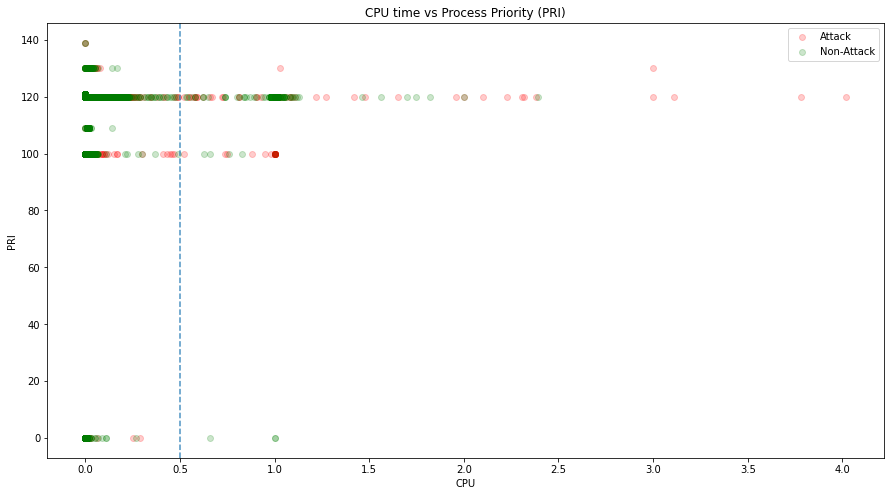

In [37]:
plt.scatter(proc_pl1_cpu1, proc_pl1_pri1, c='r', alpha=0.2, label='Attack')
plt.scatter(proc_pl1_cpu0, proc_pl1_pri0, c='g', alpha=0.2, label='Non-Attack')
plt.axvline(x=0.5, linestyle='--', alpha = 0.8)
plt.legend()
plt.xlabel('CPU')
plt.ylabel('PRI')
plt.title('CPU time vs Process Priority (PRI)')

**Discussion:** In the above plot we can observe the `CPU` time consumption of the process together with the Priority of  the process which ranges from 0 to 99 for realtime processes and 100 and above for timesharing processes. This shows that for CPU times above 0.5 (right area after the blue line) the amount of activities labeled as 'Attack' (red dots) increases considerably when compared to the green dots (not attacks). In contrast, the left area of the plot (to the left of the blue line) shows mainly green dots. For the `PRI` variable we can observe that for values greater than 100, corresponding to timesharing processes, there is a bigger proportion of red dots which correspond to attacks (also in the metadata it is mentioned that this variable is related to `NICE` so including both may lead to collinearities)

**Plot2 Process activity**

In [38]:
proc_pl2_df1 = proc_df.select('attack','State').filter(col('attack')==1)
proc_pl2_df0 = proc_df.select('attack','State').filter(col('attack')==0)
proc_pl2_df1 = proc_pl2_df1.groupBy('State').count()
proc_pl2_df0 = proc_pl2_df0.groupBy('State').count()

proc_pl2_rdd1 = proc_pl2_df1.rdd.map(lambda x: (x[0], x[1]))
proc_pl2_rdd0 = proc_pl2_df0.rdd.map(lambda x: (x[0], x[1]))

proc_pl2_status1 = proc_pl2_rdd1.map(lambda x: x[0]).collect()
proc_pl2_count1 = proc_pl2_rdd1.map(lambda x: x[1]).collect()
proc_pl2_status0 = proc_pl2_rdd0.map(lambda x: x[0]).collect()
proc_pl2_count0 = proc_pl2_rdd0.map(lambda x: x[1]).collect()

Text(0.5, 1.0, 'Count of State of process for Attack and Non-Attack records')

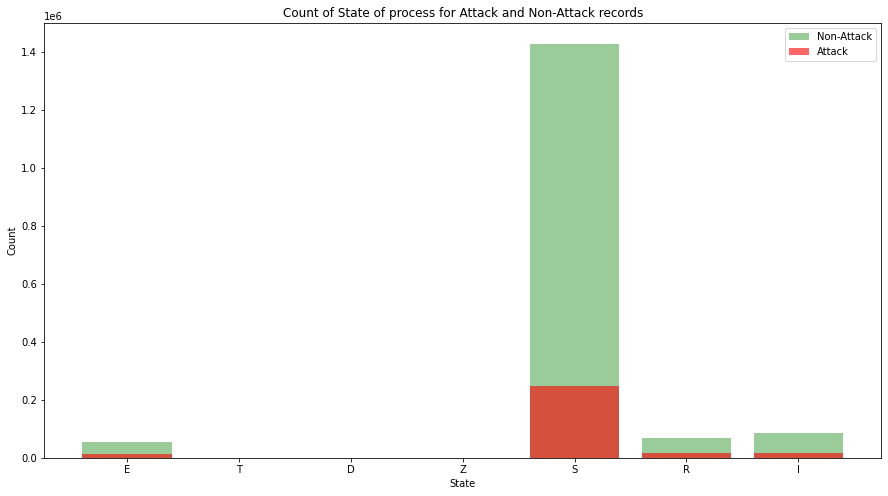

In [39]:
plt.bar(proc_pl2_status0, proc_pl2_count0, color='g', alpha=0.4, label='Non-Attack')
plt.bar(proc_pl2_status1, proc_pl2_count1, color='r', alpha=0.6, label='Attack')

plt.legend()
plt.xlabel('State')
plt.ylabel('Count')
plt.title('Count of State of process for Attack and Non-Attack records')

**Discussion:** In the above graph we observe the distribution of the different categories for *current State* of the main thread of the process (R: Running, S: Sleeping, E: exit, etc). Here we can observe that when a process presents the state R, it may have a higher proportion of cases labeled as Attack than with other levels. However, the number of processes under this category is very reduced and seems to be difficult to use this to distinguish between attack and no attack.

## Feature extraction and ML training
### Preparing the training data and testing data
1. Randomly split the dataset into 80% training data and 20% testing data for each use case

In [40]:
#Splitting the data into testing and training set
train_mem, test_mem = mem_df.randomSplit([0.8, 0.2])
train_proc, test_proc = proc_df.randomSplit([0.8, 0.2])

2. With the class imbalance observed, for the binary classification use case 1 & 2, prepare rebalanced training data, with attack events and non-attack events being 1:2 ratio, while using 20% attack events data from the training data from 2.1.1. Cache the rebalanced training data, and display the count of each event's data.  
*Here I use undersampling for this*

In [41]:
def rebalance_function(df, sple=0):
    # Get the attack events from training data
    df1 = df.filter(col('attack')==1)
    df0 = df.filter(col('attack')==0)
    
    if sple>0:        
        df1 = df1.sample(False, sple, seed = 123) # Sample 20% of the attack events found above
        attack_count = df1.count()
        # Get the non-attack events as twice the amount of attack events
        df0 = df0.sample(False, sple, seed = 123).limit(attack_count*2)
    else:
        attack_count = df1.count()
        df0 = df0.sample(False, 0.8, seed = 123).limit(attack_count*2)

    # Cache the rebalanced training data
    rebal_df = df1.union(df0)
    rebal_df.cache()
    
    return df1, df0, rebal_df

In [42]:
train_mem1, train_mem0, rebal_train_mem = rebalance_function(train_mem, 0.2)
print('Memory activity attacks count rebalanced training:',train_mem1.count())
print('Memory activity Non-attacks count rebalanced training:',train_mem0.count())
print('Memory activity Total count rebalanced training:',rebal_train_mem.count())
rebal_train_mem.storageLevel # Validating that data is cached

Memory activity attacks count rebalanced training: 32862
Memory activity Non-attacks count rebalanced training: 65724
Memory activity Total count rebalanced training: 98586


StorageLevel(True, True, False, True, 1)

In [43]:
train_proc1, train_proc0, rebal_train_proc = rebalance_function(train_proc, 0.2)
print('Process activity attacks count rebalanced training:',train_proc1.count())
print('Process activity Non-attacks count rebalanced training:',train_proc0.count())
print('Process activity Total count rebalanced training:',rebal_train_proc.count())
rebal_train_proc.storageLevel # Validating that data is cached

Process activity attacks count rebalanced training: 46605
Process activity Non-attacks count rebalanced training: 93210
Process activity Total count rebalanced training: 139815


StorageLevel(True, True, False, True, 1)

### Preparing features, labels and models
1. Based on data exploration, which features select?

From the data exploration we can see that although the `ts` gives a great insight about the importance of early detection of attacks in order to prevent future ones, it seems challenging to use this as a feature for the model. Instead, variables like `RSIZE`, `MAJFLT` and `VSTEXT` seem to be very good for detecting the cases that are associated with attacks, because those records present particularly high values for this variables, while the cases that were not associated with attacks tend to contain a lower value for these columns in the memory activity.

On the other hand, the `CPU` variable seems highly relevant and it could be combined with `PRI` as observed in the graph above. The `State` variable was also considered in the graphs and could be relevant, however it will be necessary to evaluate it to determine whether it is good for the model.

According to the nature of these variables we can observe that four of them present a numeric data type, therefore the use of indexing or one-hot encoding is not necessary. However, for the use of `State`, which is a categorical variable, will require the use of string indexing to obtain the categories in a numerical format that will then be transformed with one-hot encoding in order to obtain the data that can be transformed into features to feed our model in a next stage.

Finally, we should consider scaling the numeric data for models that rely on distance to make their predictions (for example using euclidean in K-means). This happens because they present very different units, which may affect the performance of the model as the distance difference would be distorted by the use of different units to measure the attributes. However, for models like decision tree or Gradient boosting trees it is not necessary as they don't rely on the use of distance between data points in order to classify them (in sparks documentation for GBTs it is explicitly mention that they don't require scaling https://spark.apache.org/docs/latest/mllib-ensembles.html).

2. Create Transformers / Estimators for transforming / assembling the features you selected above

**Transformer for POLI**

In [44]:
from itertools import chain

poli_dict = {'norm':0,'btch':1,'idle':2,'fifo':3,'rr':4,'0':5,'-':6}

custom_mapping = F.create_map([F.lit(x) for x in chain(*poli_dict.items())]) # https://stackoverflow.com/questions/63015500/building-custom-stringindexer-in-pyspark
proc_df = proc_df.withColumn("POLI_idx", custom_mapping[F.col("POLI")])
proc_df.show(3)

+----------+----+----+-----+-----+----+----+---+----+-----+------+---+-----+----+-----------+------+------+--------+
|        ts| PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State| CPU|        CMD|attack|  type|POLI_idx|
+----------+----+----+-----+-----+----+----+---+----+-----+------+---+-----+----+-----------+------+------+--------+
|1554218915|3257|   0|   23|    0|norm|   0|120|   0|    2|     N|  0|    S|0.13|Web-Content|     0|normal|       0|
|1554218920|1442|   0|    1|    0|norm|   0|120|   0|    0|     N|  0|    S|0.09|       Xorg|     0|normal|       0|
|1554218925|3197|   0|   63|    0|norm|   0|120|   0|    3|     N|  0|    S|0.06|    firefox|     0|normal|       0|
+----------+----+----+-----+-----+----+----+---+----+-----+------+---+-----+----+-----------+------+------+--------+
only showing top 3 rows



In [45]:
## Generating the new rebalanced data after getting POLI_idx
train_proc, test_proc = proc_df.randomSplit([0.8, 0.2])

train_proc1, train_proc0, rebal_train_proc = rebalance_function(train_proc)
print('Process activity attacks count rebalanced training:',train_proc1.count())
print('Process activity Non-attacks count rebalanced training:',train_proc0.count())
print('Process activity Total count rebalanced training:',rebal_train_proc.count())
rebal_train_proc.storageLevel # Validating that data is cached

Process activity attacks count rebalanced training: 233055
Process activity Non-attacks count rebalanced training: 466110
Process activity Total count rebalanced training: 699165


StorageLevel(True, True, False, True, 1)

**Features Memory activity**

In [46]:
from pyspark.ml.feature import VectorAssembler

# numeric columns to be included in the model 
numeric_cols = ['VSTEXT','RSIZE','MAJFLT','VSIZE']
assembler_mem = VectorAssembler(inputCols=numeric_cols, outputCol='features')

**Features Process activity**  
Here we have the `State` feature which is categorical, and we will implement the `POLI` column with the indexing that was performed above at the start of this section.

In [47]:
from pyspark.ml.feature import StringIndexer

inputCol = 'State'
outputCol = 'State_idx'

indexer_proc = StringIndexer(inputCol=inputCol, outputCol=outputCol).setHandleInvalid("keep")

In [48]:
from pyspark.ml.feature import OneHotEncoder
inputCols_OHE = ['State_idx','POLI_idx'] #input columns for OHE
outputCols_OHE = ['State_vec','POLI_vec']#output columns for OHE

#define OneHotEncoder
ohe_proc = OneHotEncoder(inputCols=inputCols_OHE, outputCols=outputCols_OHE)

In [49]:
numeric_cols_proc = ['CPU','PRI','TSLPI']

# Put together all features (numerical and no numerical)
inputColsVecAss = numeric_cols_proc+outputCols_OHE #input columns 
assembler_proc = VectorAssembler(inputCols=inputColsVecAss, outputCol='features')

3. Prepare Estimators for Decision Tree and Gradient Boosted Tree model for each use case and include them into ML Pipelines for use case 1, 2 

In [50]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'attack', maxDepth=2)
gbt = GBTClassifier(featuresCol="features", labelCol="attack", maxIter=8, maxDepth=2)

In [51]:
from pyspark.ml import Pipeline
# plug the stages into the pipline for memory
pipeline_mem_dt = Pipeline(stages=[assembler_mem, dt])
pipeline_mem_gbt = Pipeline(stages=[assembler_mem, gbt])

# plug the stages into the pipline for process
pipeline_proc_dt = Pipeline(stages=[indexer_proc, ohe_proc, assembler_proc, dt])
pipeline_proc_gbt = Pipeline(stages=[indexer_proc, ohe_proc, assembler_proc, gbt])

### Training and evaluating models
1. For each use case, use the corresponding ML Pipeline from previous step to train the models on the rebalanced training data

**Function for CV in Decision tree models**  
In order to do some hyperparameter tunning, we will design a grid for the `Decision tree` and another one for the `Gradient boosted trees` in order to find the best performing Depth, bins, and Iter (trees) for them. The following sections will contain the results of the grid using cross validation (3 folds for computing time limitations) for the `Decision tree` and `Gradient boosted trees` in each use case.

In [52]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator,CrossValidatorModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# Create ParamGrid for Cross Validation
dtparamGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [5, 9, 14])
             .addGrid(dt.maxBins, [20, 30, 40])
             .build())

gbtparamGrid = (ParamGridBuilder().addGrid(gbt.maxDepth, [8, 10])
                .addGrid(gbt.maxIter, [10, 20])
                .build())

# Define an evaluator to be used for evaluating the model 
mlevaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol='attack')

In [53]:
def ml_cv_setup(pipeline, grid, train_df, nfolds=3):
    mlcv = CrossValidator(estimator = pipeline, estimatorParamMaps = grid,
                      evaluator = mlevaluator, numFolds = nfolds) # Create 3-fold CrossValidator    
    mlcvModel = mlcv.fit(train_df) # Run cross validations
    return mlcvModel

**Memory decision tree**

In [119]:
dtcvModel1 = ml_cv_setup(pipeline_mem_dt, dtparamGrid, rebal_train_mem)

In [120]:
bestModel1 = dtcvModel1.bestModel
print(bestModel1.stages)
print('Best Param for DT memory: ', bestModel1.stages[-1]._java_obj.paramMap())

[VectorAssembler_6b0f04c0a81f, DecisionTreeClassificationModel: uid=DecisionTreeClassifier_e13b10cdc2de, depth=14, numNodes=541, numClasses=2, numFeatures=4]
Best Param for DT memory:  {
	DecisionTreeClassifier_e13b10cdc2de-featuresCol: features,
	DecisionTreeClassifier_e13b10cdc2de-labelCol: attack,
	DecisionTreeClassifier_e13b10cdc2de-maxBins: 40,
	DecisionTreeClassifier_e13b10cdc2de-maxDepth: 14
}


**Memory GBT**

In [129]:
gbtcvModel1 = ml_cv_setup(pipeline_mem_gbt, gbtparamGrid, rebal_train_mem)

bestModel2 = gbtcvModel1.bestModel
print(bestModel2.stages)
print('Best Param for DT Process activity: ', bestModel2.stages[-1]._java_obj.paramMap())

[VectorAssembler_6b0f04c0a81f, GBTClassificationModel: uid = GBTClassifier_e6daaf68d28b, numTrees=20, numClasses=2, numFeatures=4]
Best Param for DT Process activity:  {
	GBTClassifier_e6daaf68d28b-featuresCol: features,
	GBTClassifier_e6daaf68d28b-labelCol: attack,
	GBTClassifier_e6daaf68d28b-maxDepth: 10,
	GBTClassifier_e6daaf68d28b-maxIter: 20
}


**Process decision tree**

In [134]:
dtcvModel2 = ml_cv_setup(pipeline_proc_dt, dtparamGrid, rebal_train_proc)
bestModel3 = dtcvModel2.bestModel
print(bestModel3.stages)
print('Best Param for DT memory: ', bestModel3.stages[-1]._java_obj.paramMap())

[StringIndexerModel: uid=StringIndexer_b556e3764394, handleInvalid=keep, OneHotEncoderModel: uid=OneHotEncoder_0b62251b102d, dropLast=true, handleInvalid=error, numInputCols=2, numOutputCols=2, VectorAssembler_1fcb572ce4a8, DecisionTreeClassificationModel: uid=DecisionTreeClassifier_8853f11620a2, depth=14, numNodes=321, numClasses=2, numFeatures=15]
Best Param for DT memory:  {
	DecisionTreeClassifier_8853f11620a2-featuresCol: features,
	DecisionTreeClassifier_8853f11620a2-labelCol: attack,
	DecisionTreeClassifier_8853f11620a2-maxBins: 40,
	DecisionTreeClassifier_8853f11620a2-maxDepth: 14
}


**Process GBT**

In [138]:
gbtcvModel2 = ml_cv_setup(pipeline_proc_gbt, gbtparamGrid, rebal_train_proc)

bestModel4 = gbtcvModel2.bestModel
print(bestModel4.stages)
print('Best Param for DT Process activity: ', bestModel4.stages[-1]._java_obj.paramMap())

[StringIndexerModel: uid=StringIndexer_b556e3764394, handleInvalid=keep, OneHotEncoderModel: uid=OneHotEncoder_0b62251b102d, dropLast=true, handleInvalid=error, numInputCols=2, numOutputCols=2, VectorAssembler_1fcb572ce4a8, GBTClassificationModel: uid = GBTClassifier_703b6144bbc9, numTrees=15, numClasses=2, numFeatures=15]
Best Param for DT Process activity:  {
	GBTClassifier_703b6144bbc9-featuresCol: features,
	GBTClassifier_703b6144bbc9-labelCol: attack,
	GBTClassifier_703b6144bbc9-maxBins: 40,
	GBTClassifier_703b6144bbc9-maxDepth: 9,
	GBTClassifier_703b6144bbc9-maxIter: 15
}


$\,$  
*Each of the sections displayed above show the different hyperparameters of the models which were found to be the best for each case after using cross validation (with 3 folds).*

2. For each use case, test the models on the testing data and display the count of each combination of attack label and prediction label in formats as below.

**Memory decision tree**

In [121]:
prediction_memdt = pipeline_mem_Model_dt.transform(test_mem) #generate the predictions
selected_memdt = prediction_memdt.select('attack','prediction')
selected_memdt.groupBy('attack','prediction').count().show()

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0|  4288|
|     0|       0.0|135497|
|     1|       1.0| 36659|
|     0|       1.0|222480|
+------+----------+------+



**Memory GBT**

In [130]:
prediction_memgbt = bestModel2.transform(test_mem) #generate the predictions
selected_memgbt = prediction_memgbt.select('attack','prediction')
selected_memgbt.groupBy('attack','prediction').count().show()

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0|  2407|
|     0|       0.0|130100|
|     1|       1.0| 38540|
|     0|       1.0|227877|
+------+----------+------+



**Process decision tree**

In [135]:
prediction_procdt = bestModel3.transform(test_proc) #generate the predictions
selected_procdt = prediction_procdt.select('attack','prediction')
selected_procdt.groupBy('attack','prediction').count().show()

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0| 39337|
|     0|       0.0|262446|
|     1|       1.0| 19112|
|     0|       1.0| 65204|
+------+----------+------+



**Process GBT**

In [139]:
prediction_procgbt = bestModel4.transform(test_proc) #generate the predictions
selected_procgbt = prediction_procgbt.select('attack','prediction')
selected_procgbt.groupBy('attack','prediction').count().show()

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0| 39454|
|     0|       0.0|262659|
|     1|       1.0| 18995|
|     0|       1.0| 64991|
+------+----------+------+



3. Compute the AUC, accuracy, recall and precision for the attack label from each model testing result using pyspark MLlib / ML APIs. Discuss which metric is more proper for measuring the model performance on identifying attacks.

In order to compute the evaluation metrics we will create a function to print AUC, accuracy, precision, recall and F1-score. The following lines give a brief description about this metrics and a discussion about the most appropriate will be written at the end of this section.

- **Recall:** Out of all the positive cases, what proportion of them was predicted correctly? It should be high as possible.
- **Precision:** Out of all the positive cases we predicted, what proportion is actually positive?
- **Accuracy:** Out of all the cases, what proportion have we predicted correctly? It should be high as possible.
- **AUC:** represents degree or measure of separability. It tells how much the model is capable of distinguishing between classes. The higher the AUC, the better the model

In [54]:
def evaluation_metrics_func(prediction):
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol='attack')
    auc = evaluator.evaluate(prediction)
    
    # Calculate the elements of the confusion matrix
    TN = prediction.filter('prediction = 0 AND attack = 0').count()
    TP = prediction.filter('prediction = 1 AND attack = 1').count()
    FN = prediction.filter('prediction = 0 AND attack = 1').count() 
    FP = prediction.filter('prediction = 1 AND attack = 0').count() 

    # calculate metrics by the confusion matrix
    accuracy = (TP+TN)/(TP+TN+FP+FN) 
    precision = TP/(TP+FP) 
    recall = TP/(TP+FN) 
    f1 = 2/((1/recall)+(1/precision))

    print('AUC: %f\nAccuracy: %f\nPrecision: %f\nRecall: %f\nF1-score: %f' % (auc,accuracy,precision,recall,f1))

**Memory decision tree - evaluation metrics**

In [157]:
evaluation_metrics_func(prediction_memdt) 

AUC: 0.590393
Accuracy: 0.431551
Precision: 0.141465
Recall: 0.895279
F1-score: 0.244323


**Memory GBT - evaluation metrics**

In [164]:
import gc
gc.collect()

105

In [165]:
evaluation_metrics_func(prediction_memgbt)

AUC: 0.694746
Accuracy: 0.422737
Precision: 0.144660
Recall: 0.941217
F1-score: 0.250778


**Process decision tree - evaluation metrics**

In [159]:
evaluation_metrics_func(prediction_procdt) 

AUC: 0.518359
Accuracy: 0.729238
Precision: 0.226671
Recall: 0.326986
F1-score: 0.267741


**Process GBT - evaluation metrics**

In [160]:
evaluation_metrics_func(prediction_procgbt) 

AUC: 0.618913
Accuracy: 0.729486
Precision: 0.226169
Recall: 0.324984
F1-score: 0.266718


**Discussion:** After observing the results we can conclude that it is a challenging task to predict the attacks with the models. First of all, the dataset is highly unbalanced originally and after rebalancing it, we expect to have 33% attacks and 67% non-attacks. Also, the main task would consist in identifying attacks, which means that we would rather sacrifice a bit of precision in order to increase the positive cases identified. For this reason, Recall seems as highly relevant, however, we should not forget about the precision of the model, and with this in mind we would like to pay attention to the **F1-score** which involves a combined metric between Recall and precision, allowing to have a better idea of how they interact together.  
This can be seen with the model 2, where the GBT in the memory activity gave a very high Recall above 90%, however, the precision of the model was very low (just around 14%), and for this reason, the GBT on the Process activity provided a higher F1-score although the Recall was just around 33%. This shows that is better to have a more balanced model rather than a model that detects a lot of the positives (`attack` = 1) but produces a lot of false positives at the same time.

4. Display the top-5 most important features in each model. Discuss which pipeline model is better, and whether the feature “ts” should be included in the model6. And visualise the ROC curve for the better model you selected for each use case.    

In [123]:
bestModel1.stages[-1].featureImportances

SparseVector(4, {0: 0.1301, 1: 0.2783, 2: 0.0029, 3: 0.5887})

In [132]:
bestModel2.stages[-1].featureImportances

SparseVector(4, {0: 0.1282, 1: 0.2085, 2: 0.007, 3: 0.6563})

In [137]:
bestModel3.stages[-1].featureImportances

SparseVector(15, {0: 0.2222, 1: 0.1695, 2: 0.474, 3: 0.0023, 4: 0.0, 6: 0.1242, 8: 0.0001, 14: 0.0077})

In [141]:
bestModel4.stages[-1].featureImportances

SparseVector(15, {0: 0.3587, 1: 0.171, 2: 0.3859, 3: 0.0133, 4: 0.0011, 5: 0.009, 6: 0.0492, 7: 0.0045, 8: 0.0001, 14: 0.0074})

In [188]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

## Ross, A. (2019). pyspark extract ROC curve. retrieved from: https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve
class CurveMetrics(BinaryClassificationMetrics): # sub class of BinaryClassificationMetrics
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args) # superclass to access methods of the base class

    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD() # Get rdd from model of predictions
        return self._to_list(rdd) # get the list of points of the rdd 
    
def plot_roc(my_pred):
    preds = my_pred.select('attack','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['attack'])))
    points = CurveMetrics(preds).get_curve('roc')

    plt.figure()
    x_val = [x[0] for x in points]
    y_val = [x[1] for x in points]
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot(x_val, y_val)
    plt.plot([0, 1], [0, 1], 'r--')

**ROC curve Memory activity (GBT)**

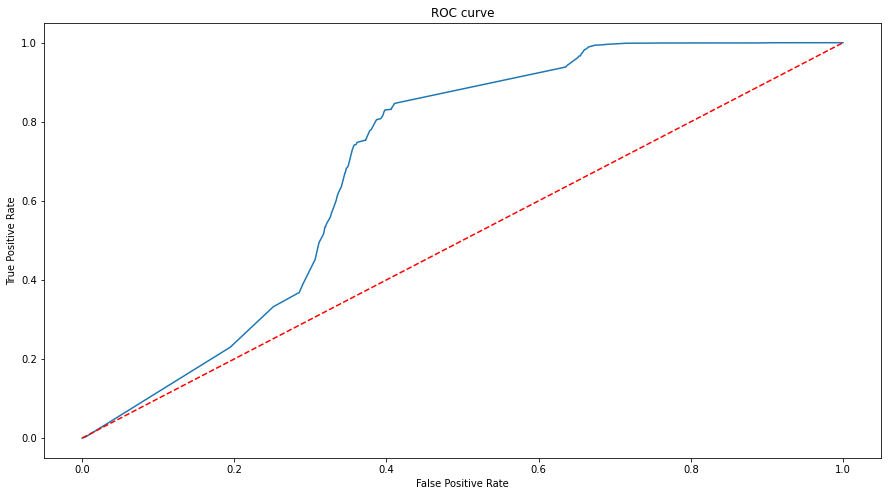

In [189]:
plot_roc(prediction_memgbt)

**ROC curve Process activity (GBT)**

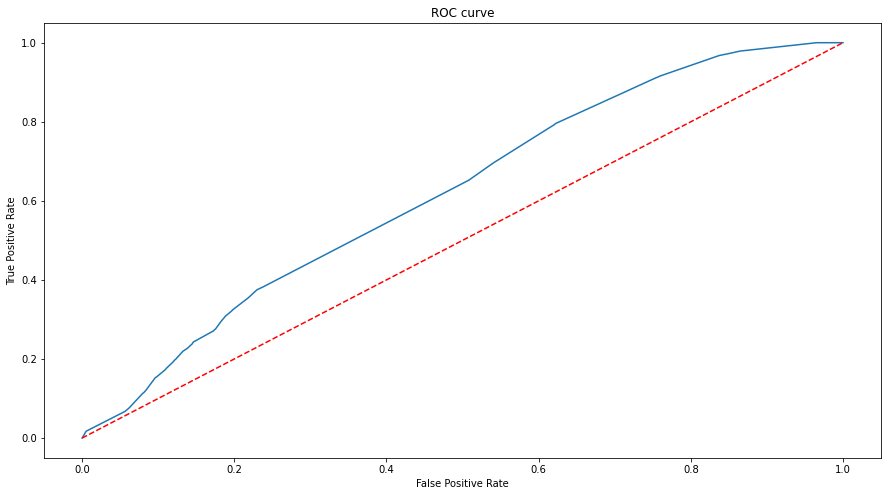

In [190]:
plot_roc(prediction_procgbt)

**Discussion:** From the results above we observed that the two models of GBTs were performing better with an AUC of 0.695 for Memory activity (model 2) and 0.62 for Process activity (model 4). It's surprising that the model 2 presents a higher AUC, considering that the precision is less than half of the one registered for model 4. This implies that the recall, or ability to identify True positives among all positive cases, is relevant to improve the separability between classes. This could be the reason why model 2 is capable of distinguishing better between classes according to the higher AUC, as it presents a Recall of above 90% compared to 33% of model 4.

Regarding the most relevant features, we used the `featureImportances` method for each model and observed that for the Memory activity the `VSIZE` (Total virtual memory usage consumed by the process) is the most relevant feature, with a score around 65% in the case of the GBT for this use case. The second place in importance for the memory activity models was for `RSIZE` (resident memory usage consumed by the process). The `VSTEXT` was the next relevant variable and finally the `MAJFLT` was the next one, with a much smaller score compared to all the others.

In the case of Process activity we had a mix of numeric and categorical variables. Here it is observed that `CPU` (CPU time consumption) and `TSLPI` (Number of threads in state 'interruptible sleeping') are by far the most relevant in distinguishing between Attack and Not Attack (together they represent around 75% of the possible score for the importance of features). The next feature is `PRI` (Process priority) with around half the score of the first two and the final top features of this use case are some of the levels from the categorical variable `State` with just around 5% relevance.

Finally, I consider `ts` feature should not be included in the model because although it can be a way to take early action once the first attack is detected (as the attacks tend to be concentrated in one specific time frame according to exploratory plots), it doesn't seem relevant to capture information of the time stamp in which an attack occurred as this may just lead to overfitting (we would be memorizing the training data rather than generalizing)

**Note:** pyspark.ml.classification, the estimate of the importance of each feature is a generalization of 'Gini' importance. The importances for tree features is normalized to sum to 1 and the values for a single tree usually present high variance (for this reason we prefer a `GBT` performing just below the `Decision tree`).

5. Using the pipeline model you selected in the previous step, re-train the pipeline model using a bigger set of rebalanced training data, with attack events and non-attack events being 1:2 ratio, while using all attack events data from the full data for both use cases. Then persist the better models for each use case.   

**Memory activity**

In [128]:
full_train_mem1, full_train_mem0, full_rebal_train_mem = rebalance_function(mem_df)
print('Memory activity attacks count rebalanced training:',full_train_mem1.count())
print('Memory activity Non-attacks count rebalanced training:',full_train_mem0.count())
print('Memory activity Total count rebalanced training:',full_rebal_train_mem.count())
full_rebal_train_mem.storageLevel # Validating that data is cached

Memory activity attacks count rebalanced training: 205623
Memory activity Non-attacks count rebalanced training: 411246
Memory activity Total count rebalanced training: 616869


StorageLevel(True, True, False, True, 1)

In [142]:
print(bestModel2.stages[-1]._java_obj.paramMap())

{
	GBTClassifier_e6daaf68d28b-featuresCol: features,
	GBTClassifier_e6daaf68d28b-labelCol: attack,
	GBTClassifier_e6daaf68d28b-maxDepth: 10,
	GBTClassifier_e6daaf68d28b-maxIter: 20
}


In [145]:
gbt2 = GBTClassifier(featuresCol="features", labelCol="attack", maxIter=20, maxDepth=10)
pipeline_mem_gbt2 = Pipeline(stages=[assembler_mem, gbt2])

model_mem_gbt = pipeline_mem_gbt2.fit(full_rebal_train_mem)

In [146]:
#Saves the model to the filesystem
model_mem_gbt.save('memory_model')

## Loading the Pipeline Model From the filesystem
# from pyspark.ml import PipelineModel
# model_mem_gbt_load = PipelineModel.load('memory_model')

**Process activity**

In [133]:
full_train_proc1, full_train_proc0, full_rebal_train_proc = rebalance_function(proc_df)
print('Process activity attacks count rebalanced training:',full_train_proc1.count())
print('Process activity Non-attacks count rebalanced training:',full_train_proc0.count())
print('Process activity Total count rebalanced training:',full_rebal_train_proc.count())
full_rebal_train_proc.storageLevel # Validating that data is cached

Process activity attacks count rebalanced training: 291364
Process activity Non-attacks count rebalanced training: 582728
Process activity Total count rebalanced training: 874092


StorageLevel(True, True, False, True, 1)

In [149]:
print(bestModel4.stages[-1]._java_obj.paramMap())

{
	GBTClassifier_703b6144bbc9-featuresCol: features,
	GBTClassifier_703b6144bbc9-labelCol: attack,
	GBTClassifier_703b6144bbc9-maxBins: 40,
	GBTClassifier_703b6144bbc9-maxDepth: 9,
	GBTClassifier_703b6144bbc9-maxIter: 15
}


In [150]:
gbt4 = GBTClassifier(featuresCol="features", labelCol="attack", maxIter=15, maxDepth=9, maxBins=40)
pipeline_proc_gbt4 = Pipeline(stages=[indexer_proc, ohe_proc, assembler_proc, gbt4])

model_proc_gbt = pipeline_proc_gbt4.fit(full_rebal_train_proc)

In [151]:
#Saves the model to the filesystem
model_proc_gbt.save('process_model')

## Loading the Pipeline Model From the filesystem
# from pyspark.ml import PipelineModel
# model_proc_gbt_load = PipelineModel.load('process_model')